In [5]:
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# XGBoost

In [6]:
train_dataset = pd.read_csv("train.csv", engine= 'pyarrow').convert_dtypes()
test_dataset =pd.read_csv("test.csv", engine= 'pyarrow').convert_dtypes()

In [7]:
categorical_columns = ['promotion', 'brand', 'manufacturer', 'category1', 'category2', 'category3']

# Option 1: Convert in the original datasets
train_dataset[categorical_columns] = train_dataset[categorical_columns].astype('category')
test_dataset[categorical_columns] = test_dataset[categorical_columns].astype('category')

In [8]:
features = ['itemID', 'qty_sold_lag1', 'qty_sold_lag2',
       'qty_sold_lag3', 'qty_sold_lag7', 'promotion', 'maxItemPrice',
       'minItemPrice', 'Price', 'PriceToday', 'medianDiscPerc', 'brand',
       'manufacturer', 'customerRating', 'category1', 'category2', 'category3',
       'recommendedRetailPrice', 'weekDay', 'day', 'weekOfMonth', 'harmonic_0',
       'harmonic_1', 'harmonic_2', 'harmonic_3', 'harmonic_4', 'cum_sum_order',
       'rolling_qty_sold_mean', 'rolling_qty_sold_std',
       'rolling_qty_sold_median', 'PricePerEach_lag1', 'PricePerEach_lag2',
       'PricePerEach_lag3', 'PricePerEach_lag7', 'sales_value_lag1',
       'sales_value_lag2', 'sales_value_lag3', 'sales_value_lag7',
       'random_noise1', 'random_noise2']
X_train = train_dataset[features]
X_test = test_dataset[features]
y_train = train_dataset["qty_sold"]
y_test = test_dataset["qty_sold"]

In [9]:
xgb_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [ ]:

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    enable_categorical = True
)

params = {
    'n_estimators': [50 , 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'reg_alpha': [1, 3, 5],
    'reg_lambda': [1, 3, 5]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    scoring='neg_root_mean_squared_error',
    cv = 5,
    verbose = 1,
    n_jobs= - 1,
    random_state= 42
)

# Fit search
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Predictions
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

# Evaluation
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

def adjusted_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - n_features - 1))
    return adj_r2

# Print results
print("Best parameters found: ", random_search.best_params_)
print(f"Train RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}")
print(f"Test RMSE:  {test_rmse:.4f}, R2: {test_r2:.4f}, R2_Adj: {adjusted_r2_score(y_test, test_preds, X_test.shape[1]):.4f}")
print(f"Train and Test R2 diff = {train_r2 - test_r2:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\Konstantin Piryankov\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
7 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Konstantin Piryankov\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Konstantin Piryankov\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\Konstantin Piryankov\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1222, in fit
    train_dmatrix, e

Best parameters found:  {'subsample': 0.5, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Train RMSE: 11.7819, R2: 0.8290
Test RMSE:  17.8423, R2: 0.8012, R2_Adj: 0.8011
Train and Test R2 diff = 0.0279


In [7]:
# params = {
#     'objective': 'reg:squarederror',
#     'max_depth': 5,
#     'learning_rate': 0.1,
#     'n_estimators': 100,
#     'random_state': 42
# }
# n=50
# model = xgb.train(params=params,dtrain=xgb_train,num_boost_round=n)

In [8]:
# preds = model.predict(xgb_test)
# preds = np.round(preds)
# accuracy = accuracy_score(y_test, preds)
# xgb_r2_score = r2_score(y_test, preds)
# print('Accuracy of the model is:', accuracy*100)
# print("R2 score of the model is:", xgb_r2_score)

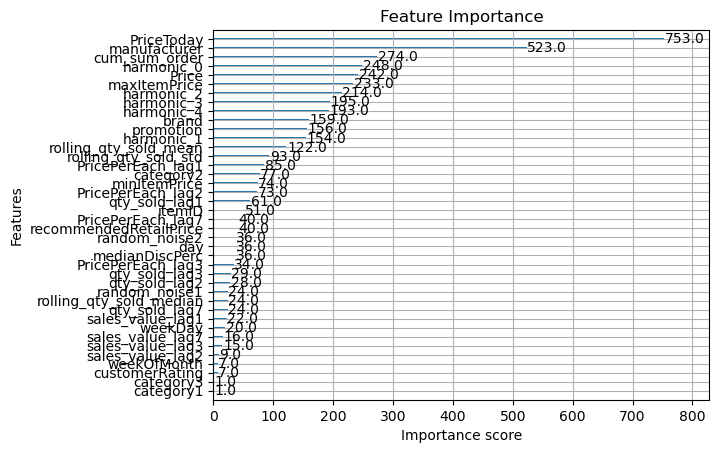

In [9]:
# Feature importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor(max_depth=5, random_state=42)
regr.fit(X_train, y_train)
regr_r2_score = regr.score(X_test, y_test)
print("R2 score of the model is:", regr_r2_score)